# Part C

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `d:\Testing_environment\Julia`


In [2]:
Pkg.add(["MarketData", "Dates", "DataFrames", "Statistics", "Plots", "StatsBase", "Distributions", "StatsPlots", 
"Images", "PrettyTables", "ARCHModels", "Flux", "LinearAlgebra", "GLM", "MLUtils", "MLDataUtils", "Optim", "CSV",
"ShiftedArrays", "MLJBase"])

   Resolving package versions...
  No Changes to `D:\Testing_environment\Julia\Project.toml`
  No Changes to `D:\Testing_environment\Julia\Manifest.toml`


In [3]:
using Pkg, MarketData, Dates, DataFrames, Statistics, StatsBase, ARCHModels, Flux, LinearAlgebra, GLM, 
Distributions, PrettyTables, StatsPlots, MLUtils, MLDataUtils, Optim, CSV, ShiftedArrays, MLJBase

**Selection of the dataset:** <br>
We employed the stock price of crude Oil between 2020-07-30 and 2024-01-01 (due to inconsistencies and missing data on early dates) and our intention is to predict the volatility of unseen data using four approximations. Garch, HAR, Feed-forward NN for HAR, and Recurrent Neural Networks for HAR.

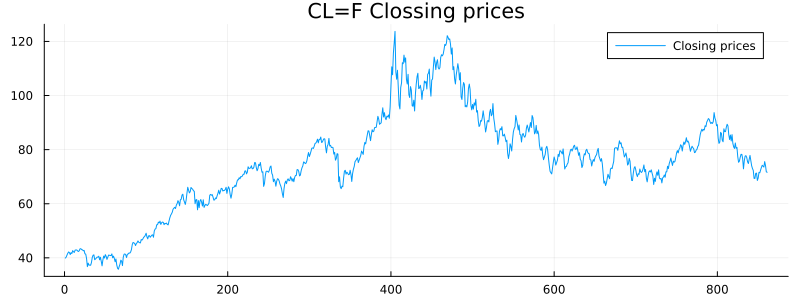

In [40]:
# data = yahoo("CL=F", YahooOpt(period1 = DateTime("2019-01-01"), period2 = DateTime("2024-01-01"))) |> DataFrame;
data = CSV.read("petrol_5y.csv", DataFrame; header=true)
data = data[400:end,:] #Cut beacause of interruption in the series
data.Price .= DateTime.(data.Price, "yyyy-mm-dd HH:MM:SS+00:00")
data[!, "Adj Close"] .= parse.(Float64, data[!, "Adj Close"]) 
data.Close .= parse.(Float64, data.Close) 
data.High .= parse.(Float64, data.High) 
data.Low .= parse.(Float64, data.Low) 
data.Open .= parse.(Float64, data.Open) 
data.Volume .= parse.(Float64, data.Volume);

plot(data.Close, size=(800,300), label="Closing prices", title ="CL=F Clossing prices")

In [5]:
first(data, 5)

Row,Price,Adj Close,Close,High,Low,Open,Volume
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-07-30T00:00:00,39.92,39.92,41.39,38.72,41.32,487325.0
2,2020-07-31T00:00:00,40.27,40.27,40.55,39.66,40.34,318788.0
3,2020-08-03T00:00:00,41.01,41.01,41.24,39.58,40.39,338326.0
4,2020-08-04T00:00:00,41.7,41.7,42.08,40.14,40.78,451575.0
5,2020-08-05T00:00:00,42.19,42.19,43.52,41.47,41.56,491268.0


As a result from our previous exercise in which the Parkinson estimation showed the best approaximation to the realized volatility. We would directly use it for this case.

In [6]:
#Functions for the estimation of realized volatility using Parkinson approach
function parkinson(data, T=1) # receives a standard yahoo finance dataframe
    return sqrt.((1/(4*T*log(2))) .* log.((data[:,3]./data[:,4])).^2)
end;

#Calculating realized volatility and log returns
prices = data.Close[1:end-1]
logrets = diff(log.(data[:, :Close]))
rv = parkinson(data)[1:end-1];

Performing train - test split, and due to the ordered nature of the data the partitions would be created without randomizing the samples.

In [ ]:
train_size = 0.8
split = length(prices) * train_size |> Int

#Splitting the series
#For raw prices
train_prices = prices[1:split]
test_prices = prices[split+1:end]

#For returns
train_logrets = logrets[1:split]
test_logrets = logrets[split+1:end]

#For realized volatility
train_rv = rv[1:split]
test_rv = rv[split+1:end];

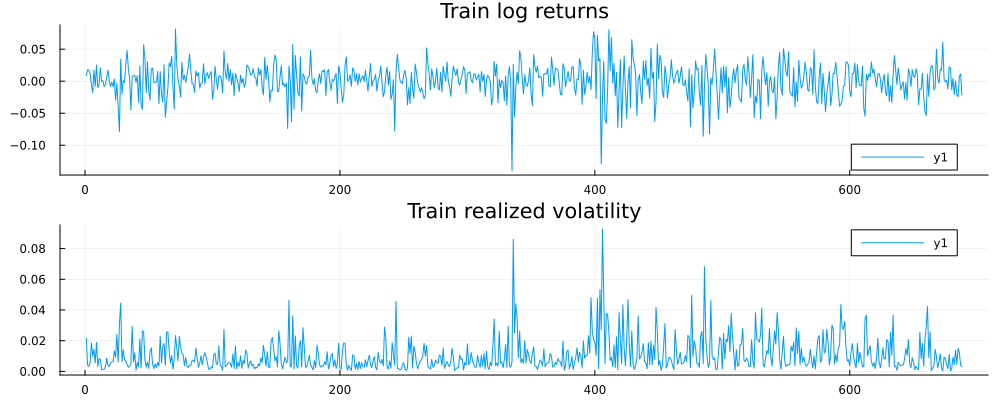

In [41]:
plot1 = plot(train_logrets, size=(1000,400), title ="Train log returns")
plot2 = plot(train_rv, size=(1000,400), title ="Train realized volatility")

plot(plot1, plot2, layout=(2, 1))

**GARCH estimation**

In [ ]:
println(ARCHLMTest(logrets, 1)) 

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          2.56883

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1090

Details:
    sample size:                    860
    number of lags:                 1
    LM statistic:                   2.56883



Having an overview of the series we are not able reject the null hypothesis that the data does not have ARCH effects. Meaning that it would not show a good explanatory power, nor predictive. Behaviour that is also adopted in the training data.

In [42]:
println(ARCHLMTest(train_logrets, 1)) #
garch_fit = ARCHModels.fit(GARCH{1, 1}, train_logrets)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          1.88085

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1702

Details:
    sample size:                    688
    number of lags:                 1
    LM statistic:                   1.88085




GARCH{1, 1} model with Gaussian errors, T=688.

Mean equation parameters:
─────────────────────────────────────────────
     Estimate    Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
μ  0.00170528  0.000853927  1.99699    0.0458
─────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   4.86263e-5  1.79509e-5   2.70884    0.0068
β₁  0.794795    0.0403604   19.6925     <1e-85
α₁  0.139764    0.0394429    3.54346    0.0004
──────────────────────────────────────────────


As anticipated, the coefficients are low, and its significance tends to rejected. The only exception is the lag of the past volatility which is marked as very significant.

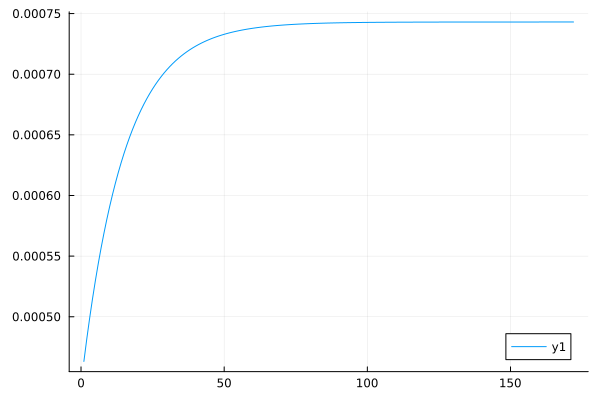

In [11]:
predictions = ARCHModels.predict.(garch_fit, :variance, 1:length(test_rv))

plot(predictions)

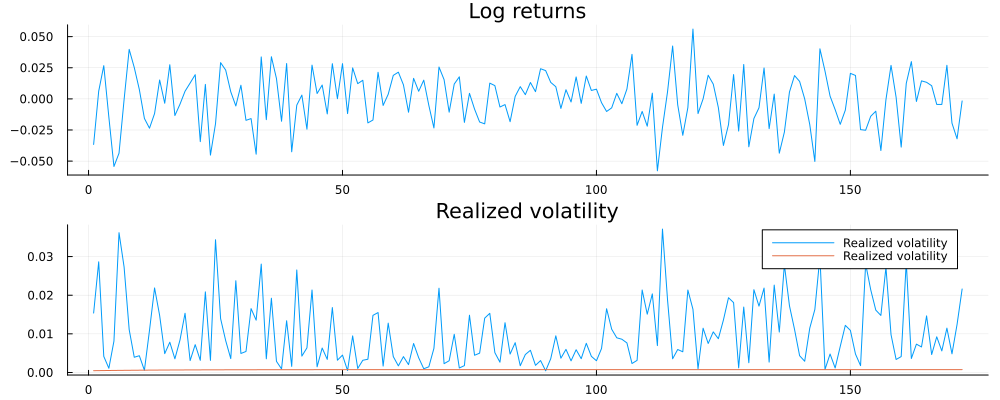

In [12]:
plot1 = plot(test_logrets, size=(1000,400), title ="Log returns", label="")
plot2 = plot(test_rv, size=(1000,400), title ="Realized volatility", label="Realized volatility")
plot2 = plot!(predictions, size=(1000,400), title ="Realized volatility", label="Realized volatility")

plot(plot1, plot2, layout=(2, 1))

As expected, in this case the GARCH model does not have much explanatory power and converges quickly to the unconditional mean close to 0.

**HAR**

In [ ]:
#Functions for the calculation of the MSE and MAE
function calculate_mse(y_actual, y_pred)
    return mean((y_actual .- y_pred).^2)
end

# Function to calculate Mean Absolute Error
function calculate_mae(y_actual, y_pred)
    return mean(abs.(y_actual .- y_pred))
end;

In [ ]:
#Create HAR regressor
function HAR_regressors(data)

    RVd = data[22:end-1] # days
    RVw = zeros(length(RVd)) # weeks
    for i in 22:(length(data)-1)
       temp = 0
       for h in 0:4
           temp = temp + data[i-h]
       end
       RVw[i-21]= temp / 5
    end
    
    RVm = zeros(length(RVd)) # months
    for i in 22:(length(data)-1) 
       temp = 0
       for h in 0:21
           temp = temp + data[i-h]
       end
       RVm[i-21] = temp / 22;
    end

    return [RVd RVw RVm]
end;

In [ ]:
#Har regression
data_har = DataFrame([train_rv[23:end] HAR_regressors(train_rv)], [:rv_t, :rv_d, :rv_w, :rv_m])
har = lm(@formula(rv_t ~ rv_d + rv_w + rv_m), data_har)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

rv_t ~ 1 + rv_d + rv_w + rv_m

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error     t  Pr(>|t|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  0.00415946  0.00112832  3.69    0.0002   0.00194394  0.00637498
rv_d         0.0711399   0.0455401   1.56    0.1187  -0.0182806   0.16056
rv_w         0.26123     0.0937726   2.79    0.0055   0.0771025   0.445357
rv_m         0.290834    0.123421    2.36    0.0187   0.0484903   0.533177
────────────────────────────────────────────────────────────────────────────

Only the week coefficient and the intercept were marked as significant.

MSE: 0.00011167347313113093
MAE: 0.007576237988950703


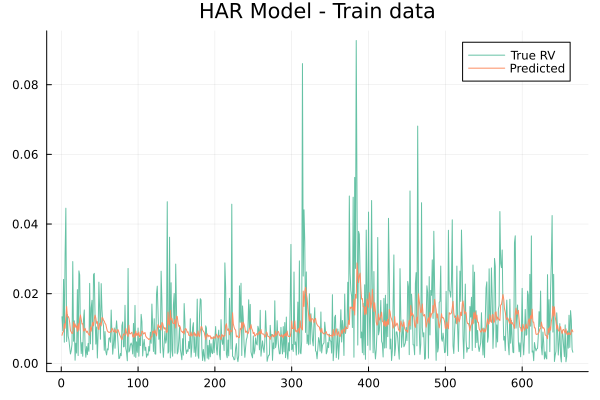

In [47]:
#In sample performance
har_prediction = GLM.predict(har);

println("MSE: ", calculate_mse(data_har.rv_t, har_prediction), "\nMAE: ", calculate_mae(data_har.rv_t, har_prediction))
plot(data_har.rv_t, lab="True RV", leg=:topright, title="HAR Model - Train data", palette=:Set2_3)
plot!(har_prediction, lab="Predicted")

MSE: 6.356140305325163e-5
MAE: 0.006528717069486764


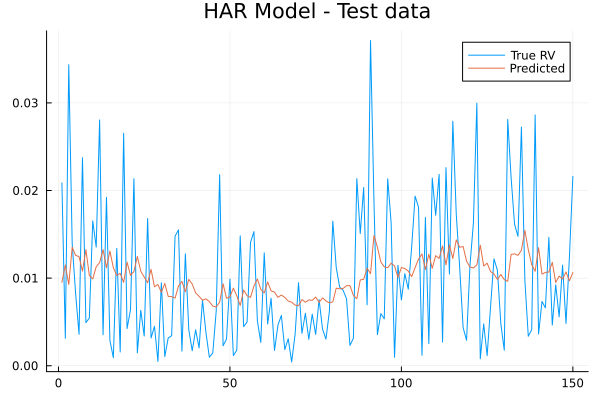

In [46]:
test_har = DataFrame([test_rv[23:end] HAR_regressors(test_rv)], [:rv_t, :rv_d, :rv_w, :rv_m]);
har_test = GLM.predict(har, test_har)

println("MSE: ", calculate_mse(test_har.rv_t, har_test), "\nMAE: ", calculate_mae(test_har.rv_t, har_test))
plot(test_har.rv_t, lab="True RV", leg=:topright, title="HAR Model - Test data")
plot!(har_test, lab="Predicted")

In terms of its performance we can observe that the series shows a good performance out-of-sample with low MSE and MAE. Not so ever, with the help of the graphs we can identify that it does not capture the peeks of volatility with ease. Therefore, we can suspect that its performance is inflated by the small range of variability seen in the test data.

**FFNN**

For the Feed-forward neural networks we would perform some transformations for normalizing the data, and additionally, would perform an extra split to obtain a verification dataset.

In [18]:
#Standardizing the data and applying a train - validation split
#Tidying the data
train_size = 0.8
x = Matrix(data_har[:, 2:4])'
y = data_har[:, 1]'

x_test = Matrix(test_har[:, 2:4])'
y_test = test_har[:, 1]'

#Creating transformations for standardizing the samples
fit_xtr = StatsBase.fit(ZScoreTransform, x; dims=2, center=true, scale=true)
fit_xts = StatsBase.fit(ZScoreTransform, x_test; dims=2, center=true, scale=true)
fit_ytr = StatsBase.fit(ZScoreTransform, y; dims=2, center=true, scale=true)
fit_yts = StatsBase.fit(ZScoreTransform, y_test; dims=2, center=true, scale=true)

#Transforming the samples
xtr_std = StatsBase.transform(fit_xtr, x)
xts_std = StatsBase.transform(fit_xts, x_test)
ytr_std = StatsBase.transform(fit_ytr, Matrix(y))
yts_std = StatsBase.transform(fit_yts, Matrix(y_test))

#Performing train val split
(x_train, y_train), (x_val, y_val) = MLDataUtils.splitobs((xtr_std, ytr_std), at = train_size)

#Creating transformations for standardizing the samples
xt_std = StatsBase.transform(fit_xtr, x_train)
xv_std = StatsBase.transform(fit_xts, x_val)
yt_std = StatsBase.transform(fit_ytr, Matrix(y_train))
yv_std = StatsBase.transform(fit_yts, Matrix(y_val));

#Calculating HAR models
tr_data = DataFrame([y_train' x_train'], [:rv, :rv_d, :rv_w, :rv_m])
val_data = DataFrame([y_val' x_val'], [:rv, :rv_d, :rv_w, :rv_m])
test_data = DataFrame([yts_std' xts_std'], [:rv, :rv_d, :rv_w, :rv_m]);

Estimation of OLS for comparable results in the three splits of the dataset.

In [19]:
#OLS with the training data
har_ols = lm(@formula(rv ~ rv_d + rv_w + rv_m), tr_data)

#Predictions
predict_train = GLM.predict(har_ols)
predict_val = GLM.predict(har_ols, val_data[:, 2:4])
predict_test = GLM.predict(har_ols, test_data[:, 2:4])

#Capturing the MSE
mse_ols_tr = Flux.Losses.mse(predict_train, tr_data[:,1])
mse_ols_v = Flux.Losses.mse(predict_val, val_data[:,1])
mse_ols_tt = Flux.Losses.mse(predict_test, test_data[:,1])

#Unifying on the same data frame
results_OLS = DataFrame(Method=String[], TrainLoss=Float64[], ValidLoss=Float64[], TestLoss=Float64[])
push!(results_OLS, ("MSE OLS", round(mse_ols_tr, digits = 6), round(mse_ols_v, digits = 6), round(mse_ols_tt, digits = 6)))

results_OLS

Row,Method,TrainLoss,ValidLoss,TestLoss
,String,Float64,Float64,Float64
1,MSE OLS,0.965246,0.725045,0.970314


In [20]:
#Activation functions to try:
a_sigmoid(x) = 1 / (1 + exp(-x)) # Sigmoid
a_relu(x) = maximum(x, 0) # ReLU
a_tanh(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x)); # tanh

In [29]:
#Neural Network function
function nn_ff(x_train, y_train, x_valid, y_valid; nodes=[5,2], eta=0.001, n_epochs=100, act_fct=identity, drop = 0.0)
    
    #Model definition
    neural_net = Chain(
                        Dense(size(x_train,1),  nodes[1]), Dropout(drop),
                        Dense(nodes[1], nodes[2], act_fct), Dropout(drop),
                        Dense(nodes[2], size(y_train,1), act_fct),
    )
    
    #Loss function
    loss(x, y) = Flux.Losses.mse(neural_net(x), y)
    
    #Performance metric
    loss1(x, y) = Flux.Losses.mse(neural_net(x), y)

    #Optimization
    opt = Descent(eta) #Optimization applying gradient descent
    # opt = ADAM(eta)
    
    # _ params 
    my_params = Flux.params(neural_net) # takes the parameters of the neural net, the weights and biases in every layer.
    orig_params = deepcopy(my_params) # Using deepcopy()to create a deep copy of a data structure, which means it creates a new instance of the data structure with a completely independent copy of its contents.
    
    best_mse_val_loss = Inf
    best_mse_val_tr_loss = Inf
    best_model = deepcopy(neural_net)

    # _ reporting 
    mse_losses_train = []
    mse_losses_valid = []
    
    # _ Train loop over the data
    for epoch in 1:n_epochs # 100 iterations by default
        # training
        Flux.train!(loss, my_params, [(x_train, y_train)], opt) #Optimization using the full sample

        push!(mse_losses_train, loss1(x_train, y_train)) # computes the loss for every iteration of the training data set
        push!(mse_losses_valid, loss1(x_valid, y_valid)) # computes the loss for every iteration of the validaton data set
        
        # saving the best model and the lowest mse 
        if best_mse_val_loss > mse_losses_valid[end]
            best_model = deepcopy(neural_net)
            best_mse_val_loss = mse_losses_valid[end]
            best_mse_val_tr_loss = mse_losses_train[end] # mse on the training data corresponding to the lowest mse on the validation data
        else
        end
    end
    
    return neural_net, best_model, best_mse_val_tr_loss, best_mse_val_loss, mse_losses_train, mse_losses_valid
end;

In [30]:
results_fnn = DataFrame(ActivationFunction=String[], Loss1=Float64[], Loss2=Float64[])
best_models_fnn = Vector{Chain}(undef, 0)
activation_functions = [identity, a_sigmoid, a_tanh, leakyrelu, relu]

# Later renaming the losses here
for act_fct in activation_functions
    model_trained01, best_model_trained_01, b_losses01, b_losses02, losses01, losses02 = nn_ff(x_train, y_train, x_val, y_val; nodes=[300,150], eta=0.01, n_epochs = 1000, act_fct=act_fct, drop = 0.0) 
    push!(results_fnn, (string(act_fct), round(b_losses01[end], digits= 6), round(b_losses02[end], digits = 6)))
    push!(best_models_fnn, best_model_trained_01)
    Flux.reset!(model_trained01)
end
results_fnn = permutedims(results_fnn,  [:identity, :a_sigmoid, :a_tanh, :leakyrelu, :relu])
results_fnn = results_fnn[2:3,:]
results_fnn.NewColumn = ["MSE-Train", "MSE-Val"]
select!(results_fnn, ncol(results_fnn), :)
results_fnn

Row,NewColumn,identity,a_sigmoid,a_tanh,leakyrelu,relu
,String,Any,Any,Any,Any,Any
1,MSE-Train,0.965973,1.02293,0.973509,0.997851,0.998972
2,MSE-Val,0.72265,0.741343,0.724178,0.73415,0.734886


From its performance we can distinguish that the best performer in both, the training and validation data, is the NN with the identity as the activation function, closely followed by tanh.

In [31]:
#Using the best models
models = best_models_fnn

#Fitting the data to the test data set
results = DataFrame(ActivationFunction=["identity", "a_sigmoid", "a_tanh", "leakyrelu", "relu"], 
Loss1=[Flux.Losses.mse(models[1](xts_std), yts_std), 
		Flux.Losses.mse(models[2](xts_std), yts_std), 
		Flux.Losses.mse(models[3](xts_std), yts_std), 
		Flux.Losses.mse(models[4](xts_std), yts_std), 
		Flux.Losses.mse(models[5](xts_std), yts_std)])

#Merging results in a dataframe
results = permutedims(results, [:identity, :a_sigmoid, :a_tanh, :leakyrelu, :relu])
results = results[2,:]
results

Row,identity,a_sigmoid,a_tanh,leakyrelu,relu
,Any,Any,Any,Any,Any
2,0.96786,0.993768,0.962694,1.00817,1.00322


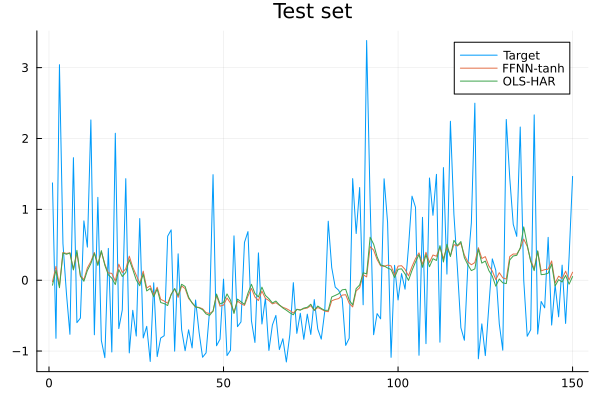

In [50]:
plot(yts_std', labels= "Target", title="Test set")
plot!(best_models_fnn[3](xts_std)', labels="FFNN-tanh")
plot!(predict_test, labels="OLS-HAR")

In terms of its out-of-sample performance, we can identify that tanh and identity had a relatively neck and neck performance and both depicted a slightly better MSE compared to the OLS estimator.

**RNN Network - LSTM**

For the RNN we would have to transform the data into chunks.

In [33]:
#Prior transformation for long-term short memory process
#The maximum quantity per node is 3 due to each column now represents a row of the split variable
xt_rnn = reshape(xt_std, 3, 1, :)
yt_rnn = reshape(yt_std, 1, 1, :)
xv_rnn = reshape(xv_std, 3, 1, :)
yv_rnn = reshape(yv_std, 1, 1, :)
xte_rnn = reshape(xts_std, 3, 1, :)
yte_rnn = reshape(yts_std, 1, 1, :);

In [ ]:
function nn_rn(x_train, y_train, x_valid, y_valid; nodes=[10, 5], eta=0.001, n_epochs=100, verbose=20, maxpatience=20, drop=0.0, lambdaW=0.0f0, act_fct=identity)
    # data
    n_in = size(x_train,1)
    n_out = size(y_train,1)

    # model
    neural_net = Chain(
                        LSTM(n_in,  nodes[1]), Dropout(drop),
                        Dense(nodes[1], nodes[2], act_fct), Dropout(drop),
                        Dense(nodes[2], n_out, act_fct)
    )

    # loss
    loss(x, y) = Flux.Losses.mse(neural_net(x), y)

    # performance metrics
    loss1(x, y) = Flux.Losses.mse(neural_net(x), y)

    opt = AdamW(eta, (0.9, 0.999), lambdaW) # AdamW stands for "Weight Decay.", regularized expression

    # params
    my_params = Flux.params(neural_net)
    orig_params = deepcopy(my_params)
    
    best_mse_val_loss = Inf
    best_mse_val_tr_loss = Inf
    best_model = deepcopy(neural_net)
    count_patience = 0

    # reporting 
    mse_losses_train = []
    mse_losses_valid = []

    # Train loop over the data
    for epoch in 1:n_epochs

        # reset hidden state every epoch before training since we begin at t=1
        Flux.reset!(neural_net)

        # training
        Flux.train!(loss, my_params, [(x_train, y_train)], opt)

        # reporting
        # Hidden validation loss
        push!(mse_losses_valid, loss1(x_valid, y_valid))

        # Reset network and run it throw the data
        Flux.reset!(neural_net)
        push!(mse_losses_train, loss1(x_train, y_train)) 

        # saving the best model and the lowest mse
        if  best_mse_val_loss > mse_losses_valid[end]
            best_model = deepcopy(neural_net)
            best_mse_val_loss = mse_losses_valid[end]
            best_mse_val_tr_loss = mse_losses_train[end] # mse on the training data corresponding to the lowest mse on the validation data
        else
            count_patience += 1
        end

        if count_patience >= maxpatience
            println(" - Epoch $epoch \t next, patience lost ")
            return neural_net, best_model, best_mse_val_tr_loss, best_mse_val_loss, mse_losses_train, mse_losses_valid
        end
    end

    return neural_net, best_model, best_mse_val_tr_loss, best_mse_val_loss, mse_losses_train, mse_losses_valid
end;

In [36]:
results_rnn = DataFrame(ActivationFunction=String[], Loss1=Float64[], Loss2=Float64[])
best_models_rnn = Vector{Chain}(undef, 0)
activation_functions = [identity, a_sigmoid, a_tanh, leakyrelu, relu]

# Later renaming the losses here
for act_fct in activation_functions
    mo1, mb1, b_l1, b_l2, l1, l2 = nn_rn(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 100], eta=0.01, n_epochs=1000, verbose=30, maxpatience=100, act_fct=act_fct, drop=0.0, lambdaW=0.0001f0)
    push!(results_rnn, (string(act_fct), round(b_l1[end], digits= 6), round(b_l2[end], digits = 6)))
    push!(best_models_rnn, mb1)
    Flux.reset!(mo1)
end

results_rnn = permutedims(results_rnn,  [:identity, :a_sigmoid, :a_tanh, :leakyrelu, :relu])
results_rnn = results_rnn[2:3,:]
results_rnn.NewColumn = ["MSE-Train", "MSE-Val"]
select!(results_rnn, ncol(results_rnn), :)
results_rnn

 - Epoch 105 	 skip, patience lost 
 - Epoch 104 	 skip, patience lost 
 - Epoch 105 	 skip, patience lost 
 - Epoch 105 	 skip, patience lost 
 - Epoch 106 	 skip, patience lost 


Row,NewColumn,identity,a_sigmoid,a_tanh,leakyrelu,relu
,String,Any,Any,Any,Any,Any
1,MSE-Train,7466.15,8663.97,8630.24,8009.87,7962.42
2,MSE-Val,10900.9,11566.4,11535.5,11232.9,11154.3


From the results we can conclude that the for this data the best RNN is the onw with the identity activation function. Not so ever, in this case we can percieve that all of the models perform poorly with a high MSE compared to the previous iterations made via FFNN and OLS.

In [37]:
#Using the best models
models = best_models_rnn

#Fitting the data to the test data set
results = DataFrame(ActivationFunction=["identity", "a_sigmoid", "a_tanh", "leakyrelu", "relu"], 
Loss1=[Flux.Losses.mse(models[1](xts_std), yts_std), 
		Flux.Losses.mse(models[2](xts_std), yts_std), 
		Flux.Losses.mse(models[3](xts_std), yts_std), 
		Flux.Losses.mse(models[4](xts_std), yts_std), 
		Flux.Losses.mse(models[5](xts_std), yts_std)])

#Merging results in a dataframe
results = permutedims(results, [:identity, :a_sigmoid, :a_tanh, :leakyrelu, :relu])
results = results[2,:]
results

Row,identity,a_sigmoid,a_tanh,leakyrelu,relu
,Any,Any,Any,Any,Any
2,70.4967,1.23475,1.99167,47.5988,176.424


In terms of out-of-sample, the role was reversed, and the identity is one of the worst performers, meanwhile sigmoid took the lead with a much lower MSE. This inversion would illustrate us a possible overfitting to the data.

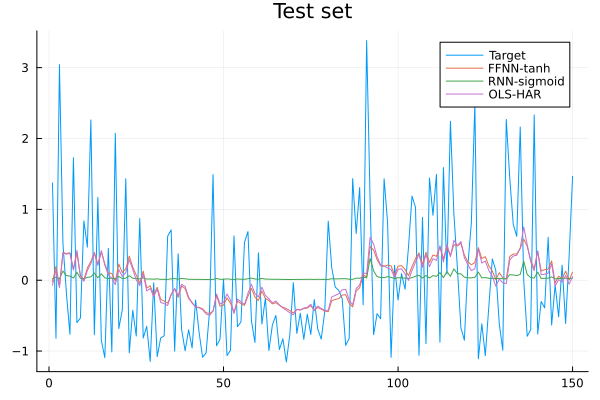

In [53]:
plot(yts_std', labels= "Target", title="Test set")
plot!(best_models_fnn[3](xts_std)', labels="FFNN-tanh")
plot!(best_models_rnn[2](xts_std)', labels="RNN-sigmoid")
plot!(predict_test, labels="OLS-HAR")

Finally, based on our performance metrics and forecast, we could conclude that the best model for this data is the FFNN with tanh activation function. Not so ever, because the unjustified complexity is not compensated by the slight reduction on the MSE. We can declare the OLS-HAR as the best model for this scenario.